In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic3"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")

from codebase import (
    load_demograhics, 
    load_buurt_data, 
    willingness_to_cycle, 
    add_willingness_to_cycle_column, 
    align_by_buurt,
    punt_buurt_code_column, 
    punt_travel_time_column,
    demographics_population_column
)

Changed to c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation


In [2]:
mode = "ebike"
punt1 = "basis"
location = "Education"

df_demographics = load_demograhics()
df_punt = load_buurt_data(punt1, mode=mode)

Loaded file from CSV


In [3]:
df_punt.describe()

,reistijd_min,reisafstand_m,afstand_hemelsbreed_m,omrijdfactor
count,9.956232e+06,9.956232e+06,9.956232e+06,9.956232e+06
mean,7.561065e+01,2.676606e+04,2.196859e+04,1.226915e+00
std,5.478498e+01,1.083328e+04,8.740672e+03,1.499960e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.200000e+01,1.906300e+04,1.564600e+04,1.160000e+00
50%,7.700000e+01,2.807200e+04,2.320900e+04,1.200000e+00
75%,9.700000e+01,3.535500e+04,2.936400e+04,1.260000e+00
max,4.104000e+03,1.670420e+05,4.076700e+04,8.335000e+01


In [4]:
df_punt, df_demographics = align_by_buurt(df_punt, df_demographics,)

Demographics and filtered dataframes do not match in length: 14405 vs 9956232, ignoring missing values


In [5]:
df_punt.describe()

,reistijd_min,reisafstand_m,afstand_hemelsbreed_m,omrijdfactor
count,14405.000000,14405.000000,14405.000000,14405.000000
mean,82.523568,26989.327803,22004.399583,1.233183
std,112.113872,11555.400914,8830.166904,0.216313
min,1.000000,216.000000,171.000000,1.000000
25%,52.000000,18768.000000,15457.000000,1.150000
50%,77.000000,28126.000000,23300.000000,1.200000
75%,97.000000,35688.000000,29557.000000,1.260000
max,3241.000000,117159.000000,35121.000000,6.960000


In [6]:
df_demographics[demographics_population_column].describe()

count    14405.000000
mean      1236.125651
std       1609.628593
min          0.000000
25%        185.000000
50%        710.000000
75%       1695.000000
max      29265.000000
Name: a_inw, dtype: float64

In [7]:
ebike_max = 25
ebike_real = 21

pedelec_max = 45
pedelec_real = 28.8

def interpolate_real_speed(speed):
    if speed <= ebike_max:
        return (speed / ebike_max) * ebike_real
    elif speed <= pedelec_max:
        return ebike_real + ((speed - ebike_max) / (pedelec_max - ebike_max)) * (pedelec_real - ebike_real)
    else:
        return pedelec_real

def speed_ratio(speed):
    interpolated = interpolate_real_speed(speed)
    return ebike_real / interpolated

col_time_base = "ebike_time_"
col_willingness_base = "ebike_willingness_"
col_willing_number_base = "ebike_willingness_number_"

range_speeds = range(25, 45)
population_willling = []

for speed in range_speeds:
    ratio = speed_ratio(speed)
    col_time = col_time_base + str(speed)
    col_willingness = col_willingness_base + str(speed)
    col_willing_number = col_willing_number_base + str(speed)

    df_punt[col_time] = df_punt[punt_travel_time_column] * ratio
    df_punt[col_willingness] = willingness_to_cycle(df_punt[col_time], location=location, mode=mode)
    df_punt[col_willing_number] = df_demographics[demographics_population_column].values * df_punt[col_willingness].values

    population_willling.append(df_punt[col_willing_number].sum())

In [8]:
speed_ratio(27)

0.9641873278236914

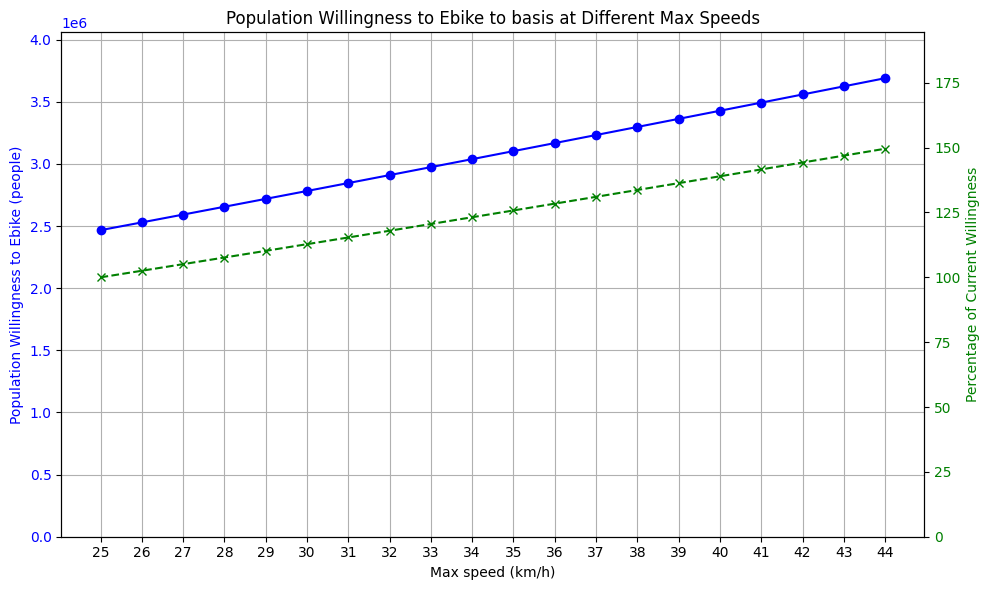

In [9]:
pop_current = population_willling[np.argwhere(np.array(range_speeds) == ebike_max)[0][0]]
percentage_change = [val / pop_current * 100 for val in population_willling]

plt.figure(figsize=(10, 6))
ax1 = plt.gca()
ax1.plot(range_speeds, population_willling, marker='o', color='b')
ax1.set_xlabel("Max speed (km/h)")
ax1.set_ylabel("Population Willingness to Ebike (people)", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(range_speeds)
ax1.set_title(f"Population Willingness to Ebike to {punt1} at Different Max Speeds")
ax1.set_ylim(0, max(population_willling) * 1.1)  # Adjust y-axis limit for better visibility
ax1.grid()

# Twin axis for proportion
ax2 = ax1.twinx()
ax2.plot(range_speeds, percentage_change, marker='x', color='g', linestyle='--')
ax2.set_ylabel("Percentage of Current Willingness", color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.set_ylim(0, max(percentage_change) * 1.3)  # Adjust y-axis limit for better visibility

plt.tight_layout()
plt.savefig(f"graphics/population_willingness_to_cycle_ebike_speeds_{punt1}.png", dpi=300)
plt.show()